In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.utils.data.dataset import random_split
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
from PIL import Image
from IPython.display import display
from sklearn.utils import compute_class_weight

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Set image size
IMG_SIZE = 256

# Transforms

In [12]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip with probability based on `do_mirror` parameter
    transforms.ColorJitter(contrast=0.2, hue=0.03, saturation=0.2),  # Apply color jitter with given ranges
    transforms.RandomAffine(degrees=20, shear=0.2),  # Apply random affine transformation with given ranges
    transforms.RandomPerspective(distortion_scale=0.1),  # Apply random perspective transformation with given range
    transforms.ToTensor()
])

Pre-processing function

In [13]:
def preprocess(img):
    # Cropping the image
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))   
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_img = np.round(gray_img * 255).astype(np.uint8)
    mask = gray_img>6
    
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0): 
        print("Image is too dark. We would crop out everything.")
        return img # return original image
    else:
        img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
        img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
        img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
        
        img = np.stack([img1,img2,img3],axis=-1)

    # Highlight relevant regions
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = np.round(img * 255).astype(np.uint8)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), 10), -4, 128)

    tensor_transform(img)
    
    return img

In [14]:
from torch.utils.data import Dataset
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, root_dir, label_file, transform):
        self.root_dir = root_dir
        self.label_file = label_file
        self.transform = transform

        # Read the labels from the csv file
        self.labels = pd.read_csv(label_file, usecols=[1], skiprows = 1, names=['diagnosis'])['diagnosis'].tolist()

        # Get the list of image files in ascending order (according to hexadecimal image file name)
        self.image_files = []
        for root, dirs, files in os.walk(root_dir):
            # Sort the files based on hexadecimal image file names
            files = sorted(files, key=lambda x: int(x.split('.')[0], 16))
            self.image_files.extend([os.path.join(root, file) for file in files])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB')
        
        # Load the image and apply the transformation
        if self.transform:
            image = self.transform(image)

        # Apply pre processing steps (cropping and highlighting)
        image = preprocess(image)

        # Convert the label to a tensor
        label = torch.tensor(self.labels[idx])
        
        return image, label
    
# Define the root directory of the dataset and the label file
base_image_dir = os.path.join('..', 'input/aptos2019-blindness-detection/')
root_dir = os.path.join(base_image_dir,'train_images/')
label_file = os.path.join(base_image_dir, 'train.csv')

data = MyDataset(root_dir, label_file, transform=train_transform)




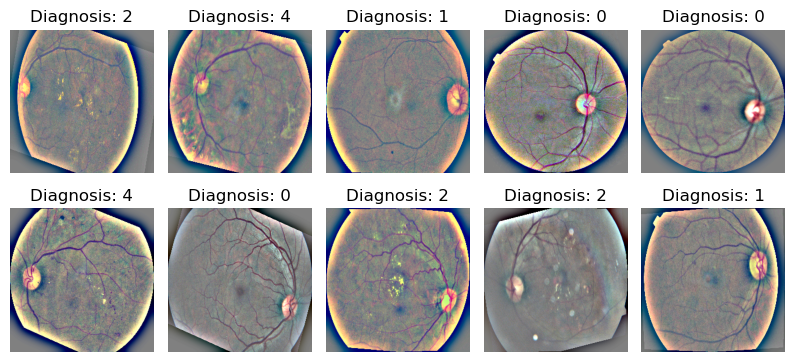

In [15]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(10, 6))

# Loop through the first 10 elements of the dataset
for i in range(10):
    # Access the image and label at index i
    image, label = data[i]
    
    # Convert the image to a PIL Image
    image = to_pil_image(image)
    
    # Get the row and column index for the subplot
    row_idx = i // 5
    col_idx = i % 5
    
    # Display the image with the label as the title on the corresponding subplot
    axes[row_idx][col_idx].imshow(image)
    axes[row_idx][col_idx].set_title(f"Diagnosis: {label.item()}")
    axes[row_idx][col_idx].axis('off')

# Adjust the layout and display the figure
plt.subplots_adjust(wspace=0.1, hspace=-0.37)
plt.show()

# Train, validate, test - Split

In [16]:
# Define the proportions for training, validation, and test sets
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Calculate the sizes of each set
num_samples = len(data)
train_size = int(train_ratio * num_samples)
val_size = int(val_ratio * num_samples)
test_size = num_samples - train_size - val_size

# Use random_split to split the dataset
train_set, val_set, test_set = random_split(data, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

print(f'Training images available: {len(train_set)}')
print(f'Validation images available:  {len(val_set)}')
print(f'Testing images available:  {len(test_set)}')

# Create the DataLoader objects for the training and validation sets
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)


Training images available: 2197
Validation images available:  732
Testing images available:  733


# Manual model training

In [17]:
EfficientNetB7 = models.efficientnet_b7(True)


# Accounting for the imbalance in the dataset

In [18]:
# Account for imbalanced dataset
class_frequencies = torch.zeros(5)  # Calculate class frequencies
total_samples = len(data)

for label in data.labels:
    class_frequencies[label] += 1

# Calculate class weights using inverse class frequency
class_weights = total_samples / (class_frequencies * 5)

print(class_weights)


tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827])


In [19]:
# Freezing parameters
for param in EfficientNetB7.parameters():
    param.requires_grad = False
  
# modifying classifier
torch.manual_seed(42)

EfficientNetB7.classifier = nn.Sequential(
                            nn.Dropout(0.5),
                            nn.Linear(2560, 5),
                            nn.LogSoftmax(dim=1))

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = torch.optim.Adam(EfficientNetB7.classifier.parameters(), lr=0.001)

for param in EfficientNetB7.classifier.parameters():
    param.requires_grad = True

In [20]:
import time
start_time = time.time()

epochs = 10

# Limit nr of batches for testing
max_trn_batch = 34 # 68.66
max_val_batch = 11 # 22.88

train_losses = []
val_losses = []
train_correct = []
val_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):

        # Limit the number of batches for testing
        if b == max_trn_batch:
            break

        b+=1 # For the calculations later
        
        # Apply the model
        # Convert input data to PyTorch tensor and specify the desired data type
        X_train = torch.tensor(X_train).to(torch.float32)  # Convert to float32
        # Transpose the dimensions of your input data to match the expected shape
        X_train = np.transpose(X_train, (0, 3, 1, 2))
        y_pred = EfficientNetB7(X_train)

        # calculate imbalance loss
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%(16) == 0:
            print(f'epoch: {i:2}  |  batch: {b:4}  |  loss: {loss.item():10.8f}  |  accuracy: {trn_corr.item()*100/(64*b):7.2f}%   |   Duration: {(time.time() - start_time)/60:.0f} minutes')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Run the testing batches
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):
            # Limit the number of batches for test
            if b == max_val_batch:
                break

            # Apply the model
            X_val = torch.tensor(X_val).to(torch.float32)  # Convert to float32
            X_val = np.transpose(X_val, (0, 3, 1, 2))
            y_val_pred = EfficientNetB7(X_val)
            loss = criterion(y_val_pred, y_val)

            # Tally the number of correct predictions
            predicted = torch.max(y_val_pred.data, 1)[1] 
            tst_corr += (predicted == y_val).sum()

    val_losses.append(loss.item())
    val_correct.append(tst_corr.item())

epoch:  0  |  batch:   16  |  loss: 1.46234012  |  accuracy:   45.31%   |   Duration: 21 minutes
epoch:  0  |  batch:   32  |  loss: 1.29383433  |  accuracy:   51.71%   |   Duration: 43 minutes
epoch:  1  |  batch:   16  |  loss: 1.22195923  |  accuracy:   60.45%   |   Duration: 81 minutes
epoch:  1  |  batch:   32  |  loss: 1.16832817  |  accuracy:   60.79%   |   Duration: 103 minutes
epoch:  2  |  batch:   16  |  loss: 1.17633414  |  accuracy:   62.01%   |   Duration: 142 minutes
epoch:  2  |  batch:   32  |  loss: 1.19655836  |  accuracy:   63.67%   |   Duration: 163 minutes
epoch:  3  |  batch:   16  |  loss: 1.04360652  |  accuracy:   67.58%   |   Duration: 201 minutes
epoch:  3  |  batch:   32  |  loss: 1.17719758  |  accuracy:   66.31%   |   Duration: 221 minutes
epoch:  4  |  batch:   16  |  loss: 1.19131517  |  accuracy:   67.09%   |   Duration: 257 minutes
epoch:  4  |  batch:   32  |  loss: 0.98312336  |  accuracy:   66.36%   |   Duration: 277 minutes
epoch:  5  |  batch:   

[1.3480067253112793, 1.2604789733886719, 1.161734938621521, 1.1827704906463623, 1.1639703512191772, 0.9545109868049622, 1.0107837915420532, 0.8595325946807861, 0.9729496240615845, 0.8584209680557251]
[1.3397327661514282, 1.1768141984939575, 1.2180267572402954, 1.141655445098877, 1.0067280530929565, 0.9473695755004883, 1.0799906253814697, 1.0464986562728882, 1.1682204008102417, 0.9588923454284668]


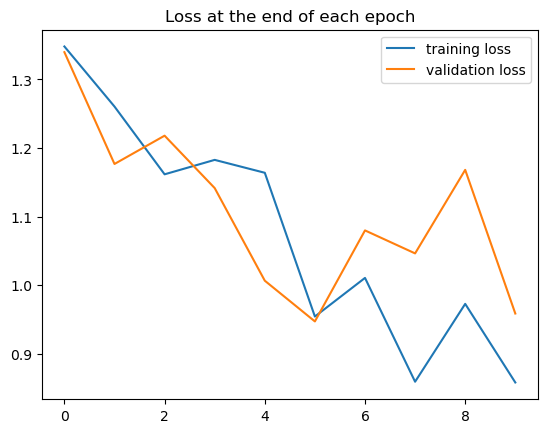

In [21]:
print(train_losses)
print(val_losses)
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

[409, 428, 431, 453, 456, 453, 441, 451, 464, 460]
Test accuracy: 65.341%


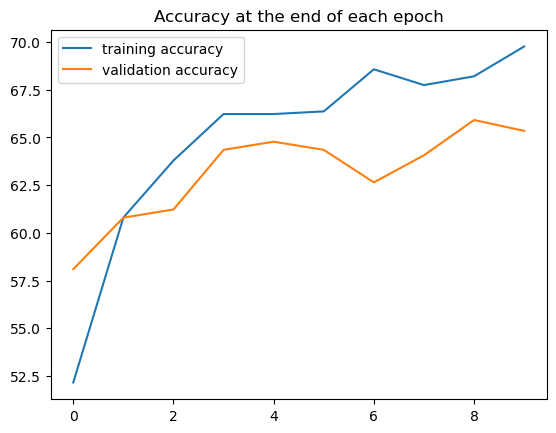

In [22]:
print(val_correct)
print(f'Test accuracy: {val_correct[-1]*100/704:.3f}%')
plt.plot([t/21.76 for t in train_correct], label='training accuracy')
plt.plot([t/7.04 for t in val_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

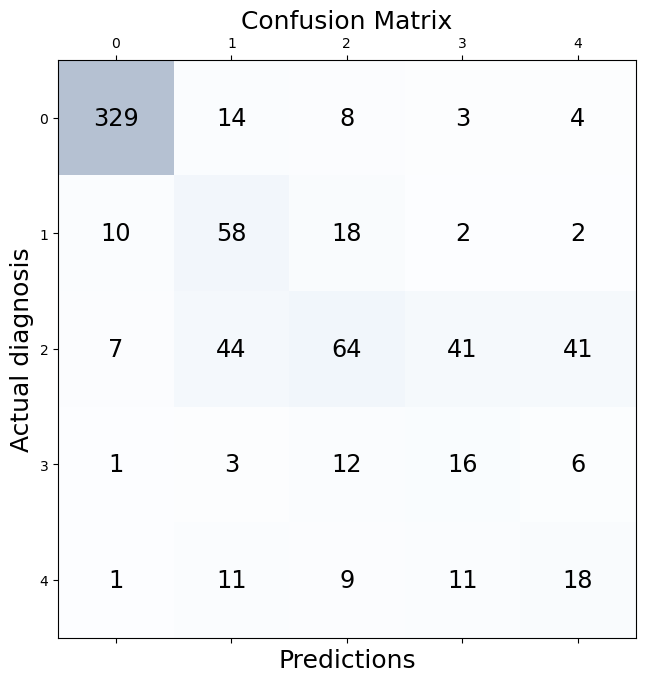

In [23]:
from sklearn.metrics import confusion_matrix

actual = []
predictions = []

# Run the testing batches
with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
        actual.extend(y_test.tolist())

        # Apply the model
        # Convert input data to PyTorch tensor and specify the desired data type
        X_test = torch.tensor(X_test).to(torch.float32)  # Convert to float32
        # Transpose the dimensions of your input data to match the expected shape
        X_test = np.transpose(X_test, (0, 3, 1, 2))
        y_val = EfficientNetB7(X_test)

        # Tally the number of correct predictions
        predicted = torch.max(y_val.data, 1)[1]
        predictions.extend(predicted.tolist())


act = np.reshape(np.array(actual), (733,))
preds = np.reshape(np.array(predictions), (733,))

conf_matrix = confusion_matrix(y_true=act, y_pred=preds)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actual diagnosis', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()